# EG557E - Genetic Algorithm Optimisation of Cold-Formed Steel Framing with Metal Additive Connection

- Author: Chuandong Xie, Alireza Bagheri Sabbagh
- Date: October 2025

# Objectives

- Train an XGBoost model to predict and moment-resisting behaviur based on `GA.zip` dataset
- Use a genetic algorithm (GA) to optimise the moment-resisting curve
    - Single objective
    - Multiple objectives
- Use Sap2000 to perform nonlinear analysis

# Requirements

Dependent packages:
- Machine learning:
    - [XGBoost](https://xgboost.readthedocs.io/en/stable/)
    - [scikit-learn](https://scikit-learn.org/stable/)
- GA:
    - [DEAP](https://deap.readthedocs.io/en/master/)
- Data process:
    - [Pandas](https://pandas.pydata.org/docs/)
    - [Numpy](https://numpy.org/doc/stable/)
- Plot:
    - [Matplotlib](https://matplotlib.org/stable/index.html)

In [1]:
# Install dependencies
!pip install pandas
!pip install numpy
!pip install sci-kit
!pip install deap
!pip install xgboost
!pip install matplotlib
!pip install tqdm

# Import

In [2]:
import pandas as pd
import numpy as np
import random
from zipfile import ZipFile
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Units

In [3]:
mm = 1.0
sec = 1.0
N = 1.0
m = 1.0e3 * mm
kg = N * sec**2 / m
g_gravity = 9.81 * m / sec**2
kN = 1.0e3 * N
Pa = N / m**2
MPa = 1.0e6 * Pa

# Connection Descriptions

## Gear-wheel (GW) and key-wheel (KW) connections

In [4]:
from IPython.display import IFrame
IFrame("GW_connection.pdf", width=500, height=400)

In [5]:
IFrame("KW_connection.pdf", width=500, height=400)

## Wheel shape

In [6]:
IFrame("wheel_shape.pdf", width=800, height=500)

Wheel shape parameters:

- Radius (RA)
- Tooth number (NT)
- Outer length ratio (OL)
- Inner length ratio (IL)
- Tooth depth ratio (TD)
- Fillet radius (FR)
- Thickness (TK)

## Two types of mental additive manufacturing process

- [Laser metal deposition (LMD)](https://www.youtube.com/watch?v=yKnlmfuMSgo)
- [Wire-arc additive manufacturing (WAAM)](https://www.youtube.com/watch?v=BVdhMLyzqFQ)

# Machine Learning Model of Idealised Curves

## Idealised moment-resisting curve

In [7]:
IFrame("idealised_curve.pdf", width=800, height=630)

## Read data

In [8]:
# Read csv and storge in a dict
filename = "GA.zip"
model_dict = {}
conn_types = ["GW_LMD", "GW_WAAM", "KW_LMD", "KW_WAAM"]
with ZipFile(filename, 'r') as csvzip:
    for conn in conn_types:
        csv = "GA_" + conn + ".csv"
        with csvzip.open(csv) as f:
            model_dict[conn] = {"df": pd.read_csv(f)}

In [9]:
model_dict["GW_WAAM"]["df"]

,radius,tooth_number,outer_length_ratio,inner_length_ratio,tooth_depth_ratio,fillet_radius,thickness,k_i,M_y,M_d,alpha_1
0,50.0,10.0,1.01,1.12,0.18,3.0,4.5,22.136002,0.268764,0.323751,0.256182
1,50.0,10.0,1.03,0.72,0.46,1.0,2.5,12.484189,0.253007,0.317938,0.174920
2,50.0,10.0,1.03,0.78,0.22,2.0,2.5,19.214920,0.259683,0.330323,0.335728
3,50.0,10.0,1.04,0.91,0.10,2.0,3.5,17.872617,0.192461,0.324333,0.616963
4,50.0,10.0,1.05,1.18,0.25,3.0,3.5,20.649047,0.268278,0.327929,0.296725
...,...,...,...,...,...,...,...,...,...,...,...
4320,65.0,9.0,0.95,0.83,0.14,3.0,2.0,37.689737,0.436260,0.531399,0.195833
4321,65.0,9.0,0.95,0.92,0.47,1.5,3.0,21.352674,0.415916,0.504626,0.143356
4322,65.0,9.0,0.97,0.96,0.17,2.0,2.5,38.483877,0.442731,0.549190,0.243119
4323,65.0,9.0,0.98,1.03,0.44,2.0,2.5,20.474042,0.378429,0.483223,0.162403


## Training model

In [10]:
# Grid search params
param_grid = {
    "estimator__n_estimators": range(50, 101, 10),
    "estimator__max_depth": range(5, 8, 1),
    "estimator__learning_rate": [0.02, 0.05, 0.1],
    "estimator__subsample": [0.8, 1.0],
    "estimator__colsample_bytree": [0.8, 1.0],
}

# Wheel parameter and objectives
wheel_params = [
    "radius", "tooth_number", "outer_length_ratio", "inner_length_ratio", 
    "tooth_depth_ratio", "fillet_radius", "thickness"
]
objectives = ["k_i", "M_y", "M_d", "alpha_1"]

# Training
for conn, item in model_dict.items():
    # Split dataset
    df = item["df"]
    X = df[wheel_params]
    y = df[objectives]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a base XGBoost model
    base_xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
    )

    # Create a XGBoost model considering multiple outputs
    multi_xgb = MultiOutputRegressor(base_xgb)

    # Grid search
    grid = GridSearchCV(
        estimator=multi_xgb,
        param_grid=param_grid,
        cv=5,
        scoring="r2",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print("Best params:", grid.best_params_)
    print("Best CV score (neg MSE):", grid.best_score_)

    # Get the best XGBoost model
    best_xgb = grid.best_estimator_
    y_pred = best_xgb.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput="uniform_average")
    print("Test R2: ", r2)

    # Save to dict
    item["X_train"] = X_train
    item["X_test"] = X_test
    item["y_train"] = y_train
    item["y_test"] = y_test
    item["grid"] = grid
    item["best_xgb"] = best_xgb
    item["r2"] = r2

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__n_estimators': 100, 'estimator__subsample': 0.8}
Best CV score (neg MSE): 0.8988470911979676
Test R2:  0.9178282022476196
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'estimator__colsample_bytree': 0.8, 'estimator__learning_rate': 0.02, 'estimator__max_depth': 7, 'estimator__n_estimators': 60, 'estimator__subsample': 0.8}
Best CV score (neg MSE): 0.4484109878540039
Test R2:  0.4930082857608795
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__n_estimators': 100, 'estimator__subsample': 0.8}
Best CV score (neg MSE): 0.9094110488891601
Test R2:  0.9087880253791809
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params:

In [11]:
test = {
    "radius": 65.0,
    "tooth_number": 6.0,
    "outer_length_ratio": 1.0,
    "inner_length_ratio": 1.0,
    "tooth_depth_ratio": 0.3,
    "fillet_radius": 3.0,
    "thickness": 2.0,
}

best_xgb.predict(pd.DataFrame([test]))


array([[18.591688  ,  0.11241976,  0.15319355,  0.1464355 ]],
      dtype=float32)

# Genetic Aligorithm Optimisation

In [12]:
IFrame("GA_tikz.pdf", width=300, height=410)

## Single objectives

### Implementation of DEAP

In [13]:
# Initialisation
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# Single objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [14]:
# Parameter space
radius_lst = np.array([65.0, 60.0, 55.0, 50.0])
tooth_number_lst = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
outer_length_ratio_lst = np.arange(0.70,1.301,0.01)
inner_length_ratio_lst = np.arange(0.70,1.301,0.01)
tooth_depth_ratio_lst = np.arange(0.10,0.501,0.01)
fillet_radius_lst = np.array([0.8, 1.0, 1.5, 2.0, 2.5, 3.0])
thickness_lst = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

# Connection type and AM process
connection_type = "KW"
connection_material = "WAAM"

In [15]:
# Toolbox
toolbox = base.Toolbox()

# Attribute generators
toolbox.register("RA_attr", random.choice, radius_lst)
toolbox.register("NT_attr", random.choice, tooth_number_lst)
toolbox.register("OL_attr", random.choice, outer_length_ratio_lst)
toolbox.register("IL_attr", random.choice, inner_length_ratio_lst)
toolbox.register("TD_attr", random.choice, tooth_depth_ratio_lst)
toolbox.register("FR_attr", random.choice, fillet_radius_lst)
toolbox.register("TK_attr", random.choice, thickness_lst)

# Individual
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (toolbox.RA_attr, toolbox.NT_attr, toolbox.OL_attr,
     toolbox.IL_attr, toolbox.TD_attr, toolbox.FR_attr,
     toolbox.TK_attr,),
)

# Population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [16]:
# Define crossover
def crossover_discrete(ind1, ind2, indpb=0.5):
    for i in range(len(ind1)):
        if random.random() < indpb:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

toolbox.register("mate", crossover_discrete, indpb=0.5)

In [17]:
# Define mutation
def mutate_discrete(individual, indpb=0.2):
    if random.random() < indpb:
        individual[0] = toolbox.RA_attr()
    if random.random() < indpb:
        individual[1] = toolbox.NT_attr()
    if random.random() < indpb:
        individual[2] = toolbox.OL_attr()
    if random.random() < indpb:
        individual[3] = toolbox.IL_attr()
    if random.random() < indpb:
        individual[4] = toolbox.TD_attr()
    if random.random() < indpb:
        individual[5] = toolbox.FR_attr()
    if random.random() < indpb:
        individual[6] = toolbox.TK_attr()
    return (individual,)

toolbox.register("mutate", mutate_discrete, indpb=0.2)

In [18]:
# Selection - single objectives
toolbox.register("select", tools.selTournament, tournsize=3)

In [19]:
# Evaluate
def evaluate_ind(individual, connection_type, connection_material):
    test = {
        "radius": individual[0],
        "tooth_number": individual[1],
        "outer_length_ratio": individual[2],
        "inner_length_ratio": individual[3],
        "tooth_depth_ratio": individual[4],
        "fillet_radius": individual[5],
        "thickness": individual[6],
    }

    # Use trained XGBoost model
    best_xgb = model_dict[f"{connection_type}_{connection_material}"]["best_xgb"]

    y_pred = best_xgb.predict(pd.DataFrame([test]))[0]
    initial_stiffness = float(y_pred[0]) # Can change to other objective
    return (initial_stiffness,)

toolbox.register("evaluate", evaluate_ind, connection_type=connection_type,
    connection_material=connection_material,)

In [20]:
# Map
toolbox.register("map", map)

In [21]:
# History logging
history = {"gen": [], "mean": [], "max": []}

def log_history(pop, gen):
    fits = [ind.fitness.values[0] for ind in pop]
    history["gen"].append(gen)
    history["mean"].append(sum(fits) / len(fits))
    history["max"].append(max(fits))

### Run GA

In [22]:
# Run GA
MU = 150    # population size
NGEN = 150  # number of generations
CXPB, MUTPB = 0.7, 0.2
random.seed(42)

# Create initial population
pop = toolbox.population(n=MU)

# Evaluate initial population
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = list(toolbox.map(toolbox.evaluate, invalid_ind))
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

# Save history
log_history(pop, gen=0)

# Evolutionary loop
for gen in tqdm(range(1, NGEN + 1), desc="GA Progress", unit="gen"):
    # print(f"Generation {gen}")

    # Variation
    offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

    # Evaluate new individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(toolbox.map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Select next generation
    pop = toolbox.select(pop + offspring, MU)

    # Save history
    log_history(pop, gen=gen)

print(f"GA optimisation of {connection_type}-{connection_material} finished.")

GA Progress: 100%|██████████| 150/150 [01:15<00:00,  2.00gen/s]

GA optimisation of KW-WAAM finished.


### Optimised result

In [23]:
# Best individual
best_ind = tools.selBest(pop, k=1)[0]
best_fit = best_ind.fitness.values[0]

print("\nBest individual:")
print("  radius             =", best_ind[0])
print("  tooth_number       =", best_ind[1])
print("  outer_length_ratio =", best_ind[2])
print("  inner_length_ratio =", best_ind[3])
print("  tooth_depth_ratio  =", best_ind[4])
print("  fillet_radius      =", best_ind[5])
print("  thickness          =", best_ind[6])
print("Predicted objectives =", best_fit)


Best individual:
  radius             = 65.0
  tooth_number       = 12
  outer_length_ratio = 0.7
  inner_length_ratio = 0.8900000000000001
  tooth_depth_ratio  = 0.2799999999999999
  fillet_radius      = 0.8
  thickness          = 4.0
Predicted objectives = 36.76490783691406


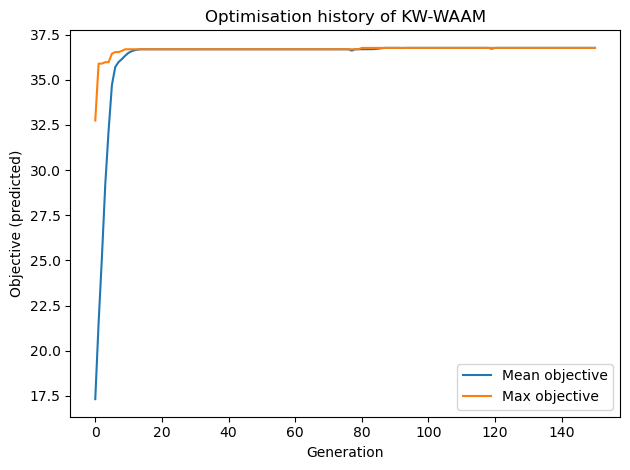

In [24]:
# Optimisation history
fig, ax = plt.subplots()
ax.plot(history["gen"], history["mean"], label="Mean objective")
ax.plot(history["gen"], history["max"], label="Max objective")
ax.set_xlabel("Generation")
ax.set_ylabel("Objective (predicted)")
ax.set_title(f"Optimisation history of {connection_type}-{connection_material}")
ax.legend()
plt.tight_layout()
plt.show()

### Idealised moment-resisting curve

In [25]:
# Use trained XGBoost to get k_i, M_y, M_d and alpha_1
def get_idealised_curve(best_ind):
    best_ind_dict = {
        "radius": best_ind[0],
        "tooth_number": best_ind[1],
        "outer_length_ratio": best_ind[2],
        "inner_length_ratio": best_ind[3],
        "tooth_depth_ratio": best_ind[4],
        "fillet_radius": best_ind[5],
        "thickness": best_ind[6],
    }
    [k_i, M_y, M_d, alpha_1] = best_xgb.predict(pd.DataFrame([best_ind_dict]))[0]
    print("Objectives: ", [k_i, M_y, M_d, alpha_1])
    
    # Note: alpha_2 and beta is assumed. Future works are needed.
    alpha_2 = -0.5
    beta = 0.5
    theta_last = 0.08
    
    # Calculate
    theta_y = M_y / k_i
    theta_d = (M_d - M_y) / (alpha_1 * k_i) + theta_y
    M_u = beta * M_y
    theta_u = (M_u - M_d) / (alpha_2 * k_i) + theta_d
    M_last = M_u
    
    # Get idealised curve
    idealised_curve = np.array([
        [0.0, 0.0],
        [theta_y, M_y],
        [theta_d, M_d],
        [theta_u, M_u],
        [theta_last, M_last],
    ])
    return idealised_curve

Objectives:  [np.float32(36.764908), np.float32(0.18953441), np.float32(0.25301886), np.float32(0.15728039)]
Idealised curve: 
[[0.         0.        ]
 [0.00515531 0.18953441]
 [0.01613422 0.25301886]
 [0.02474306 0.09476721]
 [0.08       0.09476721]]


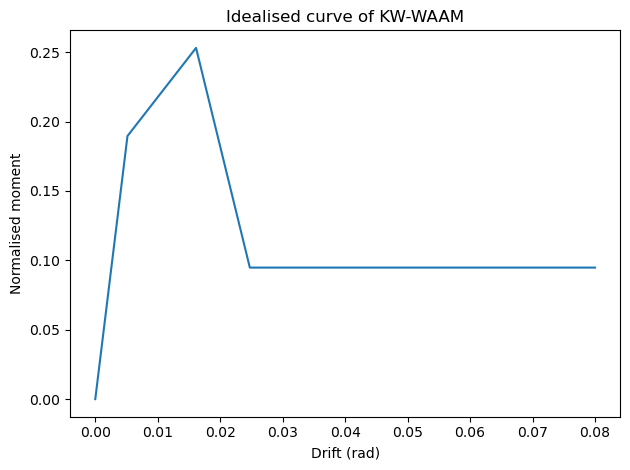

In [26]:
# Plot idealised curves
idealised_curve = get_idealised_curve(best_ind)
print(f"Idealised curve: \n{idealised_curve}")

fig, ax = plt.subplots()
ax.plot(idealised_curve[:, 0], idealised_curve[:, 1],)
ax.set_xlabel("Drift (rad)")
ax.set_ylabel("Normalised moment")
ax.set_title(f"Idealised curve of {connection_type}-{connection_material}")
plt.tight_layout()
plt.show()

## Multiple objectives

### Implementation of DEAP

In [27]:
# Parameter space
radius_lst = np.array([65.0, 60.0, 55.0, 50.0])
tooth_number_lst = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
outer_length_ratio_lst = np.arange(0.70,1.301,0.01)
inner_length_ratio_lst = np.arange(0.70,1.301,0.01)
tooth_depth_ratio_lst = np.arange(0.10,0.501,0.01)
fillet_radius_lst = np.array([0.8, 1.0, 1.5, 2.0, 2.5, 3.0])
thickness_lst = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

# Connection type and AM process
connection_type = "KW"
connection_material = "WAAM"

# Objectives
objective_weights = (1.0, 1.0, 1.0)


# Initialisation
if "FitnessMulti" in creator.__dict__:
    del creator.FitnessMulti
if "Individual" in creator.__dict__:
    del creator.Individual

creator.create("FitnessMulti", base.Fitness, weights=objective_weights)
creator.create("Individual", list, fitness=creator.FitnessMulti)

In [28]:
# Registeration
# Parameters
toolbox = base.Toolbox()
toolbox.register("RA_attr", random.choice, radius_lst)
toolbox.register("NT_attr", random.choice, tooth_number_lst)
toolbox.register("OL_attr", random.choice, outer_length_ratio_lst)
toolbox.register("IL_attr", random.choice, inner_length_ratio_lst)
toolbox.register("TD_attr", random.choice, tooth_depth_ratio_lst)
toolbox.register("FR_attr", random.choice, fillet_radius_lst)
toolbox.register("TK_attr", random.choice, thickness_lst)

# Define individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.RA_attr, toolbox.NT_attr, toolbox.OL_attr,
                  toolbox.IL_attr, toolbox.TD_attr, toolbox.FR_attr,
                  toolbox.TK_attr,))

In [29]:
# Define population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [30]:
# Define evaluate
def evaluate_ind(ind, connection_type, connection_material):
    params = {
        "radius": ind[0],
        "tooth_number": ind[1],
        "outer_length_ratio": ind[2],
        "inner_length_ratio": ind[3],
        "tooth_depth_ratio": ind[4],
        "fillet_radius": ind[5],
        "thickness": ind[6],
    }
    best_xgb = model_dict[f"{connection_type}_{connection_material}"]["best_xgb"]
    y_pred = best_xgb.predict(pd.DataFrame([params]))[0]
    return tuple(float(v) for v in y_pred[0:3])

toolbox.register("evaluate", evaluate_ind, connection_type=connection_type,
    connection_material=connection_material,)

In [31]:
# Selection
N_OBJECTIVES = 3
N_PARTITIONS = 16 #3
reference_points = tools.uniform_reference_points(N_OBJECTIVES, N_PARTITIONS)
toolbox.register("select", tools.selNSGA3, ref_points=reference_points)

# Crossover
toolbox.register("mate", crossover_discrete, indpb=0.5)

# Mutate
toolbox.register("mutate", mutate_discrete, indpb=0.2)

In [32]:
# History
history = {
    "gen": [],
    "mean_k_i": [],
    "mean_M_y": [],
    "mean_M_d": [],
    # "mean_alpha_1": [],
    "max_k_i": [],
    "max_M_y": [],
    "max_M_d": [],
    # "max_alpha_1": [],
}

def log_population(pop, gen, history):
    fits = np.array([ind.fitness.values for ind in pop])  # shape (MU, 3)

    history["gen"].append(gen)
    history["mean_k_i"].append(fits[:, 0].mean())
    history["mean_M_y"].append(fits[:, 1].mean())
    history["mean_M_d"].append(fits[:, 2].mean())
    # history["mean_alpha_1"].append(fits[:, 3].mean())

    history["max_k_i"].append(fits[:, 0].max())
    history["max_M_y"].append(fits[:, 1].max())
    history["max_M_d"].append(fits[:, 2].max())
    # history["max_alpha_1"].append(fits[:, 3].max())

### Run GA

In [33]:
MU = 150  # population size
NGEN = 150
CXPB, MUTPB = 0.7, 0.2

# Create population
pop = toolbox.population(n=MU)

# Hall of frame
hof = tools.ParetoFront()

# Evaluate initial population
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

log_population(pop, gen=0, history=history)

# Evolution loop
for gen in tqdm(range(1, NGEN + 1), desc="GA Progress", unit="gen"):
    
    # Variation (crossover + mutation)
    offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

    # Evaluate offspring with invalid fitness
    invalid_offspring = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_offspring)
    for ind, fit in zip(invalid_offspring, fitnesses):
        ind.fitness.values = fit

    # Combine parents + offspring and select next generation (NSGA-III)
    pop = toolbox.select(pop + offspring, MU)

    # Update pareto fronts
    hof.update(pop)

    log_population(pop, gen=gen, history=history)

print("GA optimisation finished.")


GA Progress: 100%|██████████| 150/150 [01:34<00:00,  1.59gen/s]

GA optimisation finished.


### Optimised results

Final Pareto front size: 113


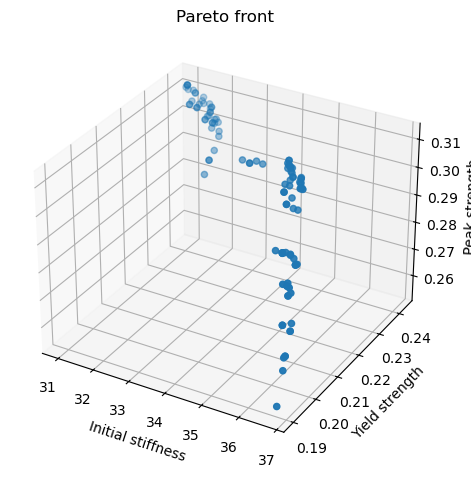

In [34]:
# Get pareto fronts
pareto_front = list(hof)
fits_pf = np.array([ind.fitness.values for ind in pareto_front])
print("Final Pareto front size:", len(pareto_front))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(fits_pf[:, 0], fits_pf[:, 1], fits_pf[:, 2])
ax.set_xlabel("Initial stiffness")
ax.set_ylabel("Yield strength")
ax.set_zlabel("Peak strength")
ax.set_title("Pareto front")
plt.tight_layout()
plt.show()


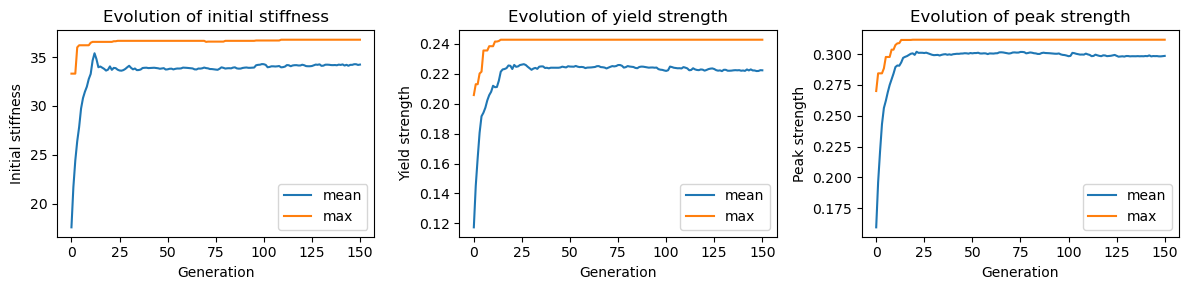

In [35]:
fig, axs = plt.subplots(ncols=3, figsize=(12,3))

gens = history["gen"]

# Initial stiffness
axs[0].plot(gens, history["mean_k_i"], label="mean")
axs[0].plot(gens, history["max_k_i"], label="max")
axs[0].set_xlabel("Generation")
axs[0].set_ylabel("Initial stiffness")
axs[0].set_title("Evolution of initial stiffness")
axs[0].legend()

# Yield strength
axs[1].plot(gens, history["mean_M_y"], label="mean")
axs[1].plot(gens, history["max_M_y"], label="max")
axs[1].set_xlabel("Generation")
axs[1].set_ylabel("Yield strength")
axs[1].set_title("Evolution of yield strength")
axs[1].legend()

# Peak strength
axs[2].plot(gens, history["mean_M_d"], label="mean")
axs[2].plot(gens, history["max_M_d"], label="max")
axs[2].set_xlabel("Generation")
axs[2].set_ylabel("Peak strength")
axs[2].set_title("Evolution of peak strength")
axs[2].legend()

# # Post-yielding stiffness ratio
# axs[3].plot(gens, history["mean_alpha_1"], label="mean")
# axs[3].plot(gens, history["max_alpha_1"], label="max")
# axs[3].set_xlabel("Generation")
# axs[3].set_ylabel("Alpha 1")
# axs[3].set_title("Evolution of alpha 1")
# axs[3].legend()

plt.tight_layout()


### Idealised moment-resisting curve

In [36]:
# Get the best with weights
weights = np.array([0.33, 0.33, 0.33])

# Pareto fronts
F = np.array([ind.fitness.values for ind in pareto_front])

# Normalise
eps = 1e-12
F_min = F.min(axis=0)
F_max = F.max(axis=0)
F_norm = (F - F_min) / (F_max - F_min + eps)
scores = np.dot(F_norm, weights)

# The best
best_idx = np.argmin(scores)
best_ind = pareto_front[best_idx]

print("Best solution using weighted sum:")
print("Objectives:", best_ind.fitness.values)
print("Design variables:", best_ind)

Best solution using weighted sum:
Objectives: (36.76490783691406, 0.18970847129821777, 0.25463008880615234)
Design variables: [np.float64(65.0), np.int64(12), np.float64(0.7), np.float64(0.8700000000000001), np.float64(0.2799999999999999), np.float64(0.8), np.float64(3.5)]


Objectives:  [np.float32(36.764908), np.float32(0.18970847), np.float32(0.2546301), np.float32(0.1568406)]
Idealised curve: 
[[0.         0.        ]
 [0.00516004 0.18970847]
 [0.01641898 0.25463009]
 [0.02511074 0.09485424]
 [0.08       0.09485424]]


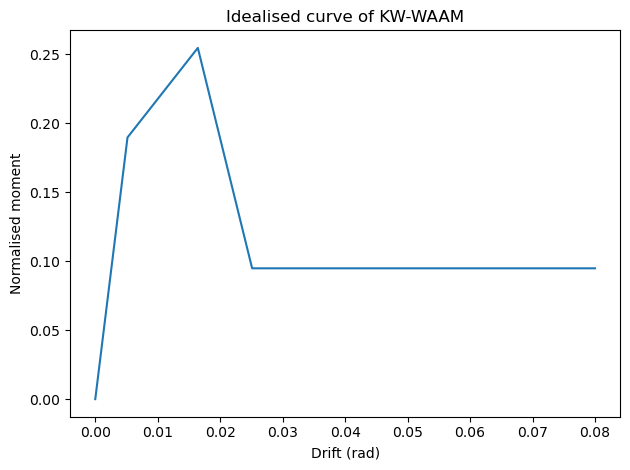

In [37]:
# Plot idealised curves
idealised_curve = get_idealised_curve(best_ind)
print(f"Idealised curve: \n{idealised_curve}")

fig, ax = plt.subplots()
ax.plot(idealised_curve[:, 0], idealised_curve[:, 1],)
ax.set_xlabel("Drift (rad)")
ax.set_ylabel("Normalised moment")
ax.set_title(f"Idealised curve of {connection_type}-{connection_material}")
plt.tight_layout()
plt.show()